In [1]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, AsymmetricPercentileInterval
import astropy.wcs
from reproject.mosaicking import reproject_and_coadd
from reproject import reproject_interp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

import sunpy.map
import sunpy.timeseries
from sunpy.net import Fido, attrs as a
from sunkit_instruments.rhessi import imagecube2map

# **Solar Data Analysis with SunPy**

![sunpy logo](./images/sunpy_logo.png)

## SPHERE Workshop / 11 July 2022

### *Will Barnes* (AU/NASA GSFC) *on behalf of the SunPy Community*
### *with many thanks to: Albert Shih (NASA GSFC), Stuart Mumford (Aperio Software), Laura Hayes (ESA ESTEC), David Stansby (UCL)*

## What is SunPy?

![sunpy core summary](./images/sunpy-summary-slide.png)

![sunpy ecosystem summary](./images/sunpy-ecosystem-slide.png)

In this tutorial, we will be looking at observations from a flare that occurred on [February 15 2011](https://hesperia.gsfc.nasa.gov/rhessi_extras/flare_images/2011/02/15/20110215_0127_0227/hsi_20110215_0127_0227.html). We'll divide this into three sections:

1. Searching for and Downloading Data
2. Loading Data into `Map` and `TimeSeries`
3. Combining Data through Reprojection

### Additional Resources

Below are a few helpful links for finding out more about SunPy, including our webpage, documentation, and our Matrix channel:

* [sunpy.org](https://sunpy.org/)
* [Installation Instructions](https://docs.sunpy.org/en/stable/)  Add link!
* [Tutorial Notebooks from 2021 AAS/SPD SunPy Workshop](https://github.com/sunpy/aas-2021-workshop)
* [Tutorial Notebooks from 2022 PyHC Summer School](https://github.com/heliophysicsPy/summer-school/tree/main/sunpy-tutorial)
* [List of Affiliated Packages](https://sunpy.org/project/affiliated.html)
* [Matrix Chat](https://openastronomy.element.io/#/room/#sunpy:openastronomy.org)
* [OpenAstronomy Discourse](https://community.openastronomy.org/c/sunpy/5)

## 1. Searching for and Downloading Data

* `Fido`is sunpy's interface for searching and downloading solar physics data.
* Unified interface for searching and fetching data.
* Search and accesses multiple instruments and all available data providers in a single query.
* In `sunpy`, `Fido` offers access to data available through: VSO, JSOC, HEK, HELIO, individual data providers from web accessible sources (http, ftp, etc)
* `clients` defined in `sunpy` or in other packages provide access to many sources of data

In [2]:
Fido

Client,Description
CDAWEBClient,Provides access to query and download from the Coordinated Data Analysis Web (CDAWeb).
EVEClient,Provides access to Level 0CS Extreme ultraviolet Variability Experiment (EVE) data.
GBMClient,Provides access to data from the Gamma-Ray Burst Monitor (GBM) instrument on board the Fermi satellite.
XRSClient,Provides access to the GOES XRS fits files archive.
SUVIClient,Provides access to data from the GOES Solar Ultraviolet Imager (SUVI).
GONGClient,Provides access to the Magnetogram products of NSO-GONG synoptic Maps.
LYRAClient,Provides access to the LYRA/Proba2 data archive.
NOAAIndicesClient,Provides access to the NOAA solar cycle indices.
NOAAPredictClient,Provides access to the NOAA SWPC predicted sunspot Number and 10.7 cm radio flux values.
SRSClient,Provides access to the NOAA SWPC solar region summary data.


To search for specific datasets, we can use 

* `a.Time`
* `a.Instrument`
* `a.Wavelength`

Let's use these different attributes to construct a query for our flare observation.

In [4]:
a.Instrument

Attribute Name,Client,Full Name,Description
aia,VSO,AIA,Atmospheric Imaging Assembly
bcs,VSO,BCS,Bragg Crystal Spectrometer
be_continuum,VSO,BE-Continuum,INAF-OACT Barra Equatoriale Continuum Instrument
be_halpha,VSO,BE-Halpha,INAF-OACT Barra Equatoriale Hα Instrument
bigbear,VSO,Big Bear,"Big Bear Solar Observatory, California TON and GONG+ sites"
caii,VSO,CAII,Kanzelhöhe Ca II k Instrument
cds,VSO,CDS,Coronal Diagnostic Spectrometer
celias,VSO,CELIAS,"Charge, Element, and Isotope Analysis System"
cerrotololo,VSO,Cerro Tololo,"Cerro Tololo, Chile GONG+ site"
chp,VSO,chp,Chromospheric Helium-I Imaging Photometer


In [5]:
flare_start = "2011-02-15T01:27"
flare_end = "2011-02-15T02:27"

Can also the `near=...` keyword to only choose a single observation in a given interval closest to a given time

In [6]:
flare_time = a.Time(flare_start, flare_end, near='2011-02-15T01:55')

In [7]:
aia_query = flare_time & a.Wavelength(193*u.angstrom) & a.Instrument.aia

In [8]:
Fido.search(aia_query)

Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size,Info
,,,,Angstrom,,,,,,,Mibyte,
Time,Time,str3,str3,float64[2],str4,str9,str6,str4,str4,str8,float64,str57
2011-02-15 01:54:57.000,2011-02-15 01:54:58.000,SDO,AIA,193.0 .. 193.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,"AIA level 1, 4096x4096 [0.034 exposure] [100.00 percentd]"


We can also logically combine queries for multiple instruments at once.
What if we also wanted to look for the STEREO and GOES XRS data during this same interval?

In [9]:
aia_query = a.Instrument.aia & a.Wavelength(193*u.angstrom)
secchi_query = a.Instrument.secchi & (a.Source('STEREO_A') | a.Source('STEREO_B')) & a.Wavelength(195*u.Angstrom)

In [10]:
goes_query = a.Instrument.xrs & a.goes.SatelliteNumber(15)

In [11]:
combined_query = Fido.search(flare_time, aia_query | secchi_query | goes_query )

In [12]:
combined_query

<sunpy.net.fido_factory.UnifiedResponse object at 0x7fa00dd5f580>
Results from 4 Providers:

1 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 67.789 Mbyte

       Start Time               End Time        Source Instrument ... Extent Length Extent Type   Size                              Info                          
                                                                  ...                            Mibyte                                                           
----------------------- ----------------------- ------ ---------- ... ------------- ----------- -------- ---------------------------------------------------------
2011-02-15 01:54:57.000 2011-02-15 01:54:58.000    SDO        AIA ...          4096    FULLDISK 64.64844 AIA level 1, 4096x4096 [0.034 exposure] [100.00 percentd]

1 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 8.41 Mbyte

       Start Time               End Time         Source  Instrument   Wavelength   Provider  Physobs  Wavetype Extent Type   Size              Info            
                                                                       Angstrom                                             Mibyte                             
----------------------- ----------------------- -------- ---------- -------------- -------- --------- -------- ----------- ------- ----------------------------
2011-02-15 01:55:30.000 2011-02-15 01:55:38.000 STEREO_A     SECCHI 195.0 .. 195.0      SSC intensity   NARROW    FULLDISK 8.02002 EUVI ;  ; NORMAL ; 2048x2048

1 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 8.41 Mbyte

       Start Time               End Time         Source  Instrument   Wavelength   Provider  Physobs  Wavetype Extent Type   Size              Info            
                                                                       Angstrom                                             Mibyte                             
----------------------- ----------------------- -------- ---------- -------------- -------- --------- -------- ----------- ------- ----------------------------
2011-02-15 01:56:03.000 2011-02-15 01:56:11.000 STEREO_B     SECCHI 195.0 .. 195.0      SSC intensity   NARROW    FULLDISK 8.02002 EUVI ;  ; NORMAL ; 2048x2048

1 Results from the XRSClient:
Source: <13: https://umbra.nascom.nasa.gov/goes/fits 
13, 14, 15: https://satdat.ngdc.noaa.gov/sem/goes/data/science/ 
16, 17: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/

       Start Time               End Time        Instrument SatelliteNumber  Physobs   Source Provider
----------------------- ----------------------- ---------- --------------- ---------- ------ --------
2011-02-15 00:00:00.000 2011-02-15 23:59:59.999        XRS              15 irradiance   GOES     NOAA

We can easily make a single download request for all of our data by passing in our combined query for AIA, STEREO, and XRS.

In [13]:
files = Fido.fetch(combined_query, path='data/{source}/{instrument}')

Files Downloaded:   0%|          | 0/4 [00:00<?, ?file/s]

In [14]:
files

['data/STEREO_B/SECCHI/20110215_015530_n4eub.fts', 'data/STEREO_A/SECCHI/20110215_015530_n4eua.fts', 'data/GOES/XRS/sci_gxrs-l2-irrad_g15_d20110215_v0-0-0.nc', 'data/SDO/AIA/aia_lev1_193a_2011_02_15t01_54_57_63z_image_lev1.fits']

## 2. Data Structures

### Loading Image Data with `Map`

We create a `sunpy.map.Map` object by passing in the FITS file for a single AIA, STEREO A, and STEREO B.

In [21]:
m_aia = sunpy.map.Map('data/SDO/AIA/aia_lev1_193a_2011_02_15t01_54_57_63z_image_lev1.fits')
m_stereo_a = sunpy.map.Map('data/STEREO_A/SECCHI/20110215_015530_n4eua.fts')
m_stereo_b = sunpy.map.Map('data/STEREO_B/SECCHI/20110215_015530_n4eub.fts')

We can easily visualize a map after loading it using the quicklook functionality.

Observatory,SDO
Instrument,AIA 2
Detector,AIA
Measurement,193.0 Angstrom
Wavelength,193.0 Angstrom
Observation Date,2011-02-15 01:54:57
Exposure Time,0.034354 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.600758 0.600758] arcsec / pix
Reference Pixel,[2045.209961 2040.089966] pix

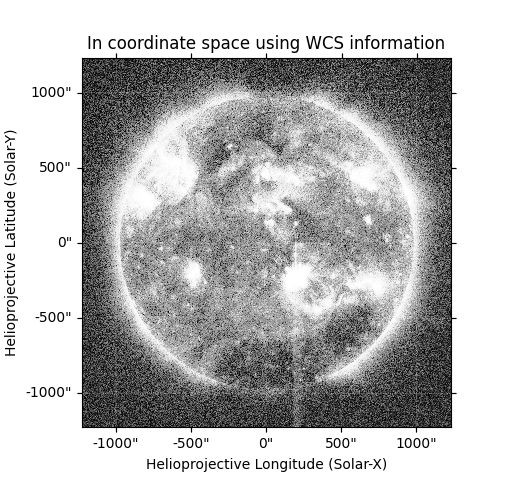
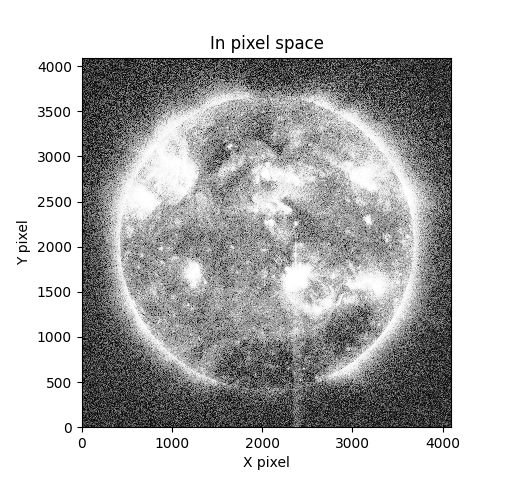
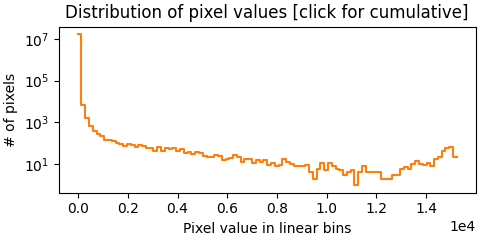
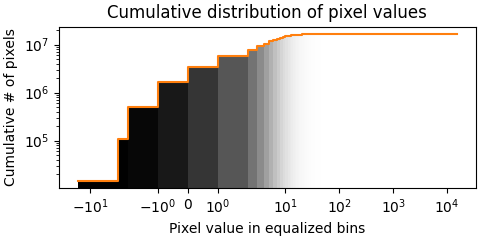

In [22]:
m_aia

### Attributes of `Map`

`Map` provides a common interface to most 2D imaging solar datasets and provides several useful pieces of metadata.
`Map` is a container for holding your data and metadata (usually from the FITS header) together.

The `.meta` and `.data` attributes provide access to the metadata and underlying array of image data, respectively.

In [24]:
m_aia.data

array([[ 2,  1, -3, ..., -2,  0, -1],
       [-2, -1,  0, ...,  2,  1,  0],
       [ 0,  0,  1, ..., -1, -2, -1],
       ...,
       [ 1,  1,  3, ...,  0,  0,  0],
       [-1,  1, -1, ...,  1,  1,  2],
       [ 0,  0, -1, ...,  0,  1,  0]], dtype=int16)

In [25]:
m_aia.meta

MetaDict([('simple', True),
          ('bitpix', 16),
          ('naxis', 2),
          ('naxis1', 4096),
          ('naxis2', 4096),
          ('pcount', 0),
          ('gcount', 1),
          ('xtension', 'BINTABLE'),
          ('bld_vers', 'V5R12X'),
          ('lvl_num', 1.0),
          ('t_rec', '2011-02-15T01:54:58Z'),
          ('trecstep', 1.0),
          ('trecepoc', '1977.01.01_00:00:00_TAI'),
          ('trecroun', 1),
          ('origin', 'SDO/JSOC-SDP'),
          ('date', '2012-10-12T23:57:02'),
          ('telescop', 'SDO/AIA'),
          ('instrume', 'AIA_2'),
          ('date-obs', '2011-02-15T01:54:57.63'),
          ('t_obs', '2011-02-15T01:54:57.65Z'),
          ('camera', 2),
          ('img_type', 'LIGHT'),
          ('exptime', 0.034354),
          ('expsdev', 0.091951),
          ('int_time', 1.234375),
          ('wavelnth', 193),
          ('waveunit', 'angstrom'),
          ('wave_str', '193_THIN'),
          ('fsn', 20786258),
          ('fid', 0),
         

However, this metadata can be terse, non-homogeneous, and sometimes difficult to parse.
`Map` provides several attributes derived from the underlying raw metadata that expose a uniform interface to the metadata for each map.

In [26]:
m_aia.date

<Time object: scale='utc' format='isot' value=2011-02-15T01:54:57.630>

In [27]:
m_aia.wavelength

<Quantity 193. Angstrom>

In [29]:
m_aia.rsun_meters

<Quantity 6.96e+08 m>

In [30]:
m_aia.rsun_obs

<Quantity 971.677059 arcsec>

In [31]:
m_stereo_a.rsun_obs

<Quantity 998.55314718 arcsec>

In [32]:
m_aia.processing_level

1.0

In [33]:
m_stereo_a.instrument

'SECCHI'

Each `Map` object also holds the unit system that the image data is in, expressed in terms of an `astropy.unit.Unit` object.

In [34]:
m_stereo_a.unit

Unit("ct")

### Coordinate Information

Each `Map` also exposes information about which coordinate system the image was taken in, including the location of the spacecraft that recorded that observation.

`sunpy` leverages and extends the powerful `astropy` coordinate framework.

For each `Map`, we can easily access what *coordinate frame* the observation cooresponds to.

In [35]:
m_aia.coordinate_frame

<Helioprojective Frame (obstime=2011-02-15T01:54:57.630, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2011-02-15T01:54:57.630, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.01164133, -6.82906212, 1.47745421e+11)>)>

Similarly, we can look at the location of the observer (as defined by the position of the satellite at the time of the observation).

In [36]:
m_aia.observer_coordinate

<SkyCoord (HeliographicStonyhurst: obstime=2011-02-15T01:54:57.630, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.01164133, -6.82906212, 1.47745421e+11)>

In [37]:
m_stereo_a.observer_coordinate

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


<SkyCoord (HeliographicStonyhurst: obstime=2011-02-15T01:55:30.005, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (87.0613866, -2.80377654, 1.43666681e+11)>

In [38]:
m_stereo_b.observer_coordinate

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


<SkyCoord (HeliographicStonyhurst: obstime=2011-02-15T01:56:03.628, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-93.73437593, 3.22309394, 1.53744911e+11)>

We can plot these observer coordinates to show the relative position, in heliographic longitude, of each spacecraft.
Additionally, the [SolarMACH tool](https://solar-mach.github.io/) provides a web interface for building similar visualizations.

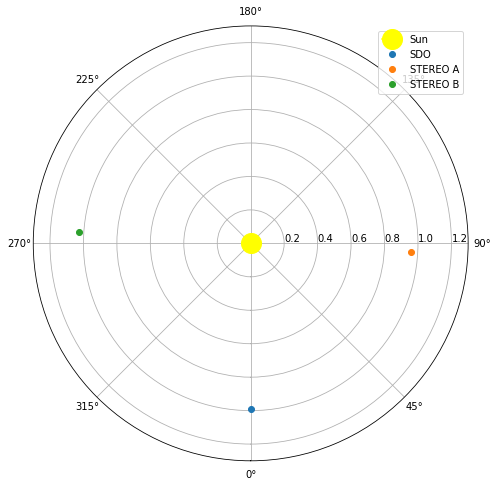

In [39]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection='polar')

# Plot the Sun
ax.plot(0, 0, marker='o', markersize=20, label='Sun', color='yellow')

# Plot the satellite locations
for m in [m_aia, m_stereo_a, m_stereo_b]:
    sat = m.observatory
    coord = m.observer_coordinate
    ax.plot(coord.lon.to('rad'), coord.radius.to(u.AU), 'o', label=sat)

ax.set_theta_zero_location("S")
ax.set_rlabel_position(90)
ax.set_rlim(0, 1.3)
ax.legend()

We can also use this coordinate information to overplot the flare position in each map.
We can easily locate the approximate flare position in the AIA image.

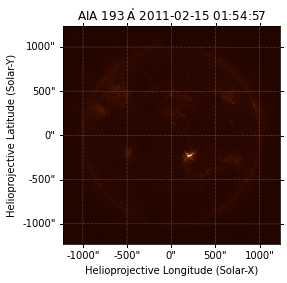

In [41]:
m_aia.plot()

In [42]:
flare_location = SkyCoord(Tx=200*u.arcsec, Ty=-220*u.arcsec, frame=m_aia.coordinate_frame)

And transform it to the coordinate frame of either STEREO satellite

In [43]:
flare_location.transform_to(m_stereo_a.coordinate_frame)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


<SkyCoord (Helioprojective: obstime=2011-02-15T01:55:30.005, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2011-02-15T01:55:30.005, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (87.0613866, -2.80377654, 1.43666681e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, m)
    (-907.75605156, -324.52412931, 1.43481899e+11)>

In [44]:
flare_location.transform_to(m_stereo_b.coordinate_frame)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


<SkyCoord (Helioprojective: obstime=2011-02-15T01:56:03.628, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2011-02-15T01:56:03.628, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-93.73437593, 3.22309394, 1.53744911e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, m)
    (842.73145358, -299.97670211, 1.53943089e+11)>

Note that we can use the `plot_coord` command to overlay this coordinate on each `Map` and perform this transformation automatically before plotting

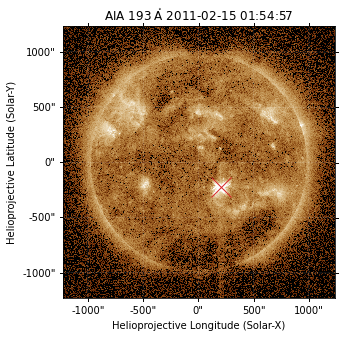

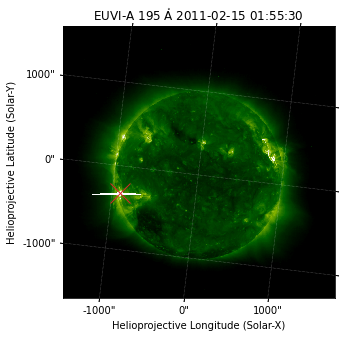

In [46]:
for i, m in enumerate([m_aia, m_stereo_a,]):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection=m)
    im = m.plot(axes=ax, clip_interval=(10,99.9)*u.percent)
    # Manually plot flare location
    ax.plot_coord(flare_location, ls=' ', marker='x', color='C3', markersize=20)

### Visualization

`Map` provides some additional "helpers" for plotting the associated image data with the correct projection based on the WCS.
At a minimum, this can be accomplished through the `.plot()` method.

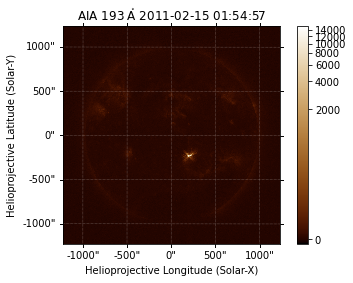

In [51]:
m_aia.plot()
plt.colorbar()

This "automagically" creates a figure and an axis (with a projection based on the WCS of the map) and plots our map on that axis, with a colormap and normalization tailored for the specific map source.
All of this visualization is built on top of `matplotlib` and the `WCSAxes` capabilities provided by `astropy` that we saw demoed earlier today.
However, as you can see, the resulting default colorbar is not particularly useful.

Because all of this plotting capability is built on top of `matplotlib`, we can easily customize the various components of our plot.

We can explictly create the axis and add the projection for the map if we want more fine-grained control over labels and titles.
We can also easily adjust the limits on our colorbar using the `clip_interval` key.

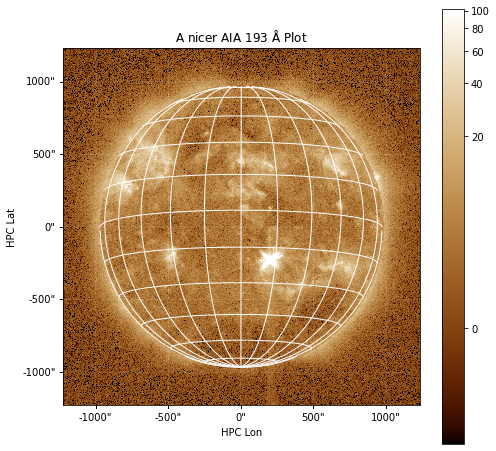

In [93]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=m_aia)
im = m_aia.plot(axes=ax, clip_interval=(1,99.9)*u.percent)
m_aia.draw_grid(axes=ax, lw=1, alpha=1)
ax.set_title(r'A nicer AIA 193 $\mathrm{\AA}$ Plot')
ax.coords[0].set_axislabel('HPC Lon')
ax.coords[1].set_axislabel('HPC Lat')
fig.colorbar(im)

Using `matplotlib` combined with `WCSAxes`, we can build more complex, publication-quality visualizations.

(**NOTE:** It is not necessary to fully understand every intricacy of the plotting code below during the course of the tutorial. This is merely to show how `Map.plot` can be be used to make more complex plots.)

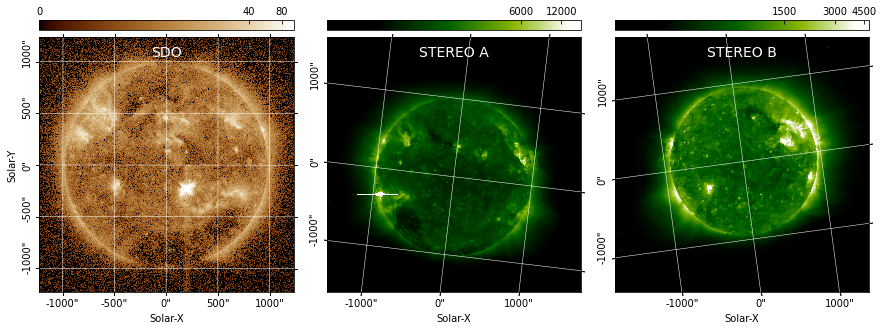

In [53]:
fig = plt.figure(figsize=(15,5))

for i, m in enumerate([m_aia, m_stereo_a, m_stereo_b]):
    # Create the axis with the appropriate projection
    ax = fig.add_subplot(1, 3, i+1, projection=m)
    
    # Add the plot to the axis
    im = m.plot(axes=ax, annotate=False, clip_interval=(10,99.9)*u.percent)
    
    # Make the HPC grid lines visible
    ax.coords.grid(alpha=1, ls='-')
    
    # Adjust the labels and ticks
    if i > 0:
        ax.coords[1].set_auto_axislabel(False)
    else:
        ax.coords[1].set_axislabel('Solar-Y')
    ax.coords[0].set_axislabel('Solar-X')
    ax.coords[1].set_ticklabel(rotation=90,)
    
    # Put a label on each plot
    ax.text(m.data.shape[1]//2, m.data.shape[0]*.97, m.observatory,
            color='w',
            horizontalalignment='center',
            verticalalignment='top',
            fontsize=14)
    
    # Add a colorbar to the top of each plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('top', size='4%', pad=0.1, axes_class=matplotlib.axes.Axes)
    cb = fig.colorbar(im, cax=cax, orientation='horizontal')
    cax.xaxis.set_ticks_position("top")
    cax.xaxis.set_tick_params(direction='in',)
    cb.locator = matplotlib.ticker.MaxNLocator(nbins=3)
    cb.update_ticks()
    
plt.subplots_adjust(wspace=0.1)

### Animating RHESSI Image Cubes with `MapSequence`

In addition, the `MapSequence` container provides a data container for holding multiple maps, such as in the case where you have a sequence of maps taken at successive times.

Let's download the CLEAN image cube for this particular flare from the RHESSI flare archive: https://hesperia.gsfc.nasa.gov/rhessi_extras/flare_images/2011/02/15/20110215_0127_0227/hsi_20110215_0127_0227.html.
We can then use the [`sunkit-instruments`](https://docs.sunpy.org/projects/sunkit-instruments/en/stable/index.html) package to load this data into a `MapSequence`.

In [54]:
rhessi_cube = imagecube2map('data/hsi_imagecube_clean_20110215_0127_41tx5e.fits')

In [55]:
rhessi_cube.keys()

dict_keys(['6-12 keV', '12-25 keV', '25-50 keV', '50-100 keV', '100-300 keV'])

The `MapSequence` can be indexed to return the individual `Map` objects at each time step.

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


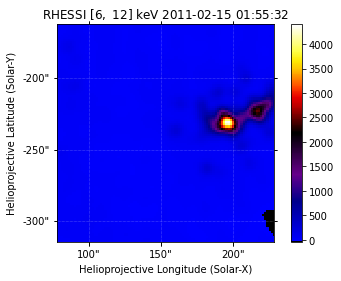

In [56]:
rhessi_cube['6-12 keV'][20].peek()

One of the most useful features of a `MapSequence` is the ability to create coordinate-aware visualizations of our stack of `Map` objects.
To do this, we'll first create a a colormap normalization appropriate to the range of the data for every map in our stack.

In [57]:
vmax = np.max(rhessi_cube['25-50 keV'].as_array())
norm=ImageNormalize(vmin=0, vmax=vmax) 

The `plot` method on our `MapSequence` object now returns an animation rather than a simple static plot.

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


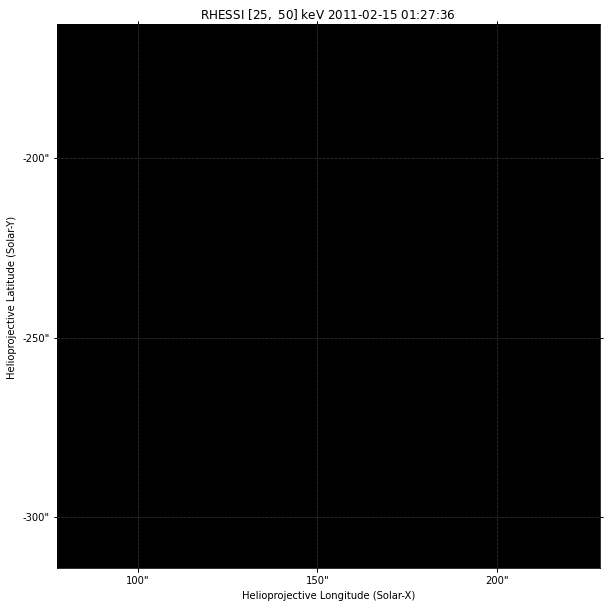

In [58]:
plt.figure(figsize=(10,10))
rhessi_ani = rhessi_cube['25-50 keV'].plot(norm=norm)

In [59]:
HTML(rhessi_ani.to_jshtml())

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]
 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


 [sunpy.map.mapbase]


### Rotating Images

The `.rotate` method applies a rotation in the image plane, i.e. about an axis out of the page. 
In the case where we do not specify an angle (or rotation matrix), the image will be rotated such that the world and pixel axes are aligned.
In the case of an image in helioprojective coordinate system, this means that solar north will be aligned with the y-like pixel axis of the image.

In [ ]:
m_stereo_a_rot = m_stereo_a.rotate()

In [ ]:
fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot(121,projection=m_stereo_a)
m_stereo_a.plot(axes=ax, vmin=800, vmax=5e3)
ax.coords.grid(alpha=1, ls='-')
ax = fig.add_subplot(122,projection=m_stereo_a_rot)
m_stereo_a_rot.plot(axes=ax, vmin=800, vmax=5e3)
ax.coords.grid(alpha=1, ls='-')

This rotation is also reflected in the updated metadata of the rotated image.

In [ ]:
m_stereo_a.rotation_matrix

In [ ]:
m_stereo_a_rot.rotation_matrix

### Cropping Images with `submap`

We commonly want to pare down our full field-of-view to a particular region of interest.
With a map, we can do this using the `submap` method.

In [ ]:
m_stereo_a_rot_cropped = m_stereo_a_rot.submap(SkyCoord(-1500*u.arcsec, -1500*u.arcsec, frame=m_stereo_a_rot.coordinate_frame),
                                               width=3000*u.arcsec, height=3000*u.arcsec)

In [ ]:
m_stereo_a_rot_cropped.plot(vmin=800, vmax=5e3)

Additionally, we can use the corners of our RHESSI maps to crop our full-disk AIA image to the FOV that RHESSI observed.

In [ ]:
m_aia_cropped = m_aia.submap(rhessi_cube['6-12 keV'][0].bottom_left_coord,
                             top_right=rhessi_cube['6-12 keV'][0].top_right_coord)

In [ ]:
m_aia_cropped.plot()

We can then lay the contours from one of our RHESSI images on top of our cropped AIA data.

In [ ]:
rhessi_cube['6-12 keV'][19].date

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=m_aia_cropped)
m_aia_cropped.plot(axes=ax)
rhessi_cube['6-12 keV'][19].draw_contours(np.arange(5,100,5)*u.percent, axes=ax, alpha=0.75, cmap='viridis')

## The `Timeseries` Data Structure

In addition to `Map` for 2D image data, `sunpy` also provides a container for tabular time series data through the `TimeSeries` class.
We can create a `TimeSeries` object in a very similar manner to how we create a `Map` object.

Let's look at the corresponding GOES XRS data that we downloaded in the previous notebook.

In [ ]:
ts = sunpy.timeseries.TimeSeries('data/GOES/XRS/sci_gxrs-l2-irrad_g15_d20110215_v0-0-0.nc')

In [ ]:
ts

As with `Map`, `TimeSeries` acts as a container for the data + metadata. We can access each component individually.

In [ ]:
ts.meta

The `TimeSeries` object can also be converted to other formats like a `pandas` `DataFrame`

In [ ]:
ts.to_dataframe()

There are also a number of attributes on each `TimeSeries` derived from the data/metadata.

In [ ]:
ts.columns

In [ ]:
ts.observatory

In [ ]:
ts.source

In [ ]:
ts.units

### Slicing and Visualizing `TimeSeries`

Note that this intensity `TimeSeries` spans 24 h of observation time and recall that we are only interested in the ~3 h interval in which the CME is visible in the 304 channel.
We can truncate our timeseries around the times of interest.
To do this, we can actually use the `date` property on our first and last EUI map from our sequence.

In [ ]:
ts_flare = ts.truncate(flare_start, flare_end)

And then do a quicklook on our lightcurve.

In [ ]:
ts_flare

## Combining Image Data from Multiple Observers

When combining these images all three need to assume the same radius of
the Sun for the data. The AIA images specify a slightly different value
than the IAU 2015 constant. To avoid coordinate transformation issues we
reset this here.



In [60]:
m_stereo_a.meta['rsun_ref'] = sunpy.sun.constants.radius.to_value(u.m)
m_stereo_b.meta['rsun_ref'] = sunpy.sun.constants.radius.to_value(u.m)
m_aia.meta['rsun_ref'] = sunpy.sun.constants.radius.to_value(u.m)

The next step is to calculate the output coordinate system for the combined
map. We select a heliographic Stonyhurst frame, and a Plate Carree (CAR)
projection, and generate a header using `sunpy.map.make_fitswcs_header` and
then construct a World Coordinate System (WCS) object for that header.



In [61]:
shape_out = (360, 720)  # This is set deliberately low to reduce memory consumption
reference_coordinate = SkyCoord(0, 0, unit=u.deg, frame="heliographic_stonyhurst", obstime=m_aia.date)
scale = [360 / shape_out[1], 180 / shape_out[0]] * u.deg / u.pix

In [62]:
header = sunpy.map.make_fitswcs_header(shape_out,
                                       reference_coordinate,
                                       scale=scale,
                                       wavelength=m_aia.wavelength,
                                       projection_code="CAR")
out_wcs = astropy.wcs.WCS(header)

Next we call the `reproject.mosaicking.reproject_and_coadd` function, which
takes a list of maps, and the desired output WCS and array shape.



In [63]:
maps = [m_aia, m_stereo_a, m_stereo_b]

In [64]:
array,_ = reproject_and_coadd(maps, out_wcs, shape_out, reproject_function=reproject_interp)

In [65]:
combined_map = sunpy.map.Map(array, header)

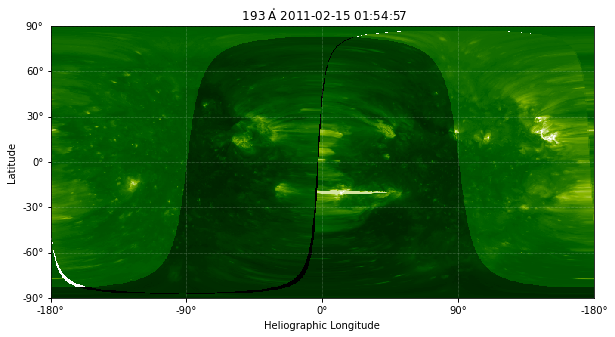

In [67]:
plt.figure(figsize=(10,5))
combined_map.plot(cmap='euvi195', norm=m_aia.plot_settings['norm'])

As you can see this leaves a little to be desired. To reduce the obvious warping towards the points which are close to the limb in the input images, we can define a set of weights to use when co-adding the output arrays.
To reduce this warping we want to calculate an set of weights which highly weight points close to the center of the disk in the input image.

We can achieve this by using sunpy's coordinate framework. First we calculate all the world coordinates for all the pixels in all three input maps.

In [68]:
coordinates = tuple(map(sunpy.map.all_coordinates_from_map, maps))

To get a weighting which is high close to disk centre and low towards
the limb, we can use the Z coordinate in the heliocentric frame. This
coordinate is the distance of the sphere from the centre of the Sun
towards the observer.



In [69]:
weights = [coord.transform_to("heliocentric").z.value for coord in coordinates]

These weights are good, but they are better if the ramp down is a little
smoother, and more biased to the centre. Also we can scale them to the
range 0-1, and set any off disk (NaN) regions to 0.



In [70]:
weights = [(w / np.nanmax(w)) ** 1.5 for w in weights]
for w in weights:
    w[np.isnan(w)] = 0

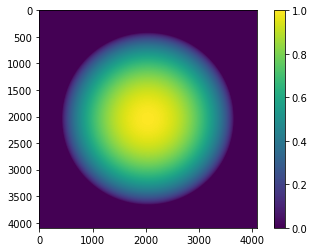

In [71]:
plt.imshow(weights[0])
plt.colorbar()

Now we can rerun the reprojection. This time we also set
``match_background=True`` which scales the images by a single scaling
factor so they are of similar brightness. We also set
``background_reference=0`` which uses the AIA map as the reference for
the background scaling.

In [88]:
array, _ = reproject_and_coadd(maps[:2], out_wcs, shape_out,
                               input_weights=weights,
                               reproject_function=reproject_interp,
                               match_background=False,
                               background_reference=0)

Once again we create a new map from our reprojected array and new header.

In [89]:
combined_map = sunpy.map.Map(array, header)

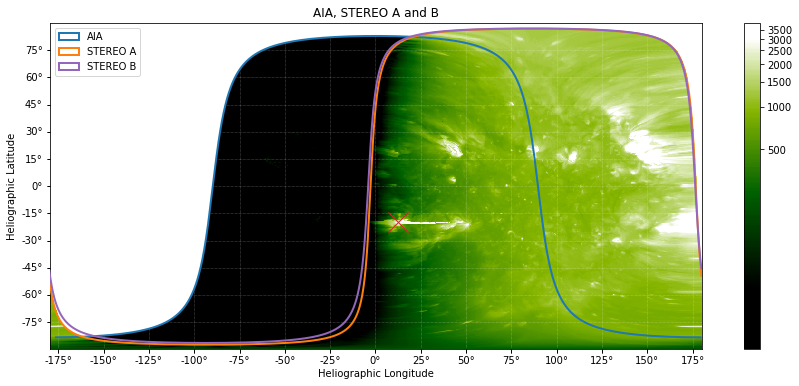

In [90]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(projection=combined_map)
im = combined_map.plot(axes=ax, cmap='euvi195', norm=m_aia.plot_settings['norm'],
                       clip_interval=(1,99.5)*u.percent,
                       title='AIA, STEREO A and B')

# Fix the tick formatting
lon, lat = ax.coords
lon.set_coord_type("longitude")
lon.coord_wrap = 180
lon.set_format_unit(u.deg)
lat.set_coord_type("latitude")
lat.set_format_unit(u.deg)

# Fix the labeling
lon.set_axislabel('Heliographic Longitude', minpad=0.8)
lat.set_axislabel('Heliographic Latitude', minpad=0.9)
lon.set_ticks(spacing=25*u.deg, color='k')
lat.set_ticks(spacing=15*u.deg, color='k')

# Reset the view to pixel centers
_ = ax.axis((0, shape_out[1], 0, shape_out[0]))

# Draw the limb as defined by each spacecraft
m_aia.draw_limb(axes=ax, lw=2, color='C0', label='AIA')
m_stereo_a.draw_limb(axes=ax, lw=2, color='C1', label='STEREO A')
m_stereo_b.draw_limb(axes=ax, lw=2, color='C4', label='STEREO B')

# Plot approximate flare position
ax.plot_coord(flare_location, ls=' ', marker='x', color='C3', markersize=20)
    
# Add the legend and colorbar
plt.legend(loc=2)
plt.colorbar(im, ax=ax)